In [1]:
import numpy as np
import pandas as pd
import os

from env import StockLearningEnv
import config

from stable_baselines3 import DDPG
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3 import SAC

from pyfolio import timeseries
from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings

warnings.filterwarnings("ignore")

E:\Anaconda\envs\finrl\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### 导入测试环境

In [2]:
trade_df = pd.read_csv('./data_file/trade.csv')
e_trade_gym = StockLearningEnv(df=trade_df, **config.ENV_TRADE_PARAMS)

加载数据缓存
数据缓存成功!


### ensemble算法

In [3]:
def ensemble_pred(models, obs):
    actions = []
    for model in models:
        action, _states = model.predict(obs)
        actions.append(action)
    return np.mean(actions, axis=0)

### 导入已训练好的模型

In [4]:
episode = 50000
episodes = [50000, 100000, 150000, 200000]
for episode in episodes:
    model_A2C_trained = A2C(policy='MlpPolicy', env=e_trade_gym, **config.A2C_PARAMS)
    model_A2C_trained.load(os.path.join('train_file', "{}.model".format('A2C' + str(episode))))

    model_DDPG_trained = DDPG(policy='MlpPolicy', env=e_trade_gym, **config.DDPG_PARAMS)
    model_DDPG_trained.load(os.path.join('train_file', "{}.model".format('DDPG' + str(episode))))

    model_PPO_trained = PPO(policy='MlpPolicy', env=e_trade_gym, **config.PPO_PARAMS)
    model_PPO_trained.load(os.path.join('train_file', "{}.model".format('PPO' + str(episode))))

    model_SAC_trained = SAC(policy='MlpPolicy', env=e_trade_gym, **config.SAC_PARAMS)
    model_SAC_trained.load(os.path.join('train_file', "{}.model".format('SAC' + str(episode))))

    model_TD3_trained = TD3(policy='MlpPolicy', env=e_trade_gym, **config.TD3_PARAMS)
    model_TD3_trained.load(os.path.join('train_file', "{}.model".format('TD3' + str(episode))))

    test_env_A2C, test_obs_A2C = e_trade_gym.get_sb_env()
    test_env_DDPG, test_obs_DDPG = e_trade_gym.get_sb_env()
    test_env_PPO, test_obs_PPO = e_trade_gym.get_sb_env()
    test_env_SAC, test_obs_SAC = e_trade_gym.get_sb_env()
    test_env_TD3, test_obs_TD3 = e_trade_gym.get_sb_env()
    test_env_ensemble, test_obs_ensemble = e_trade_gym.get_sb_env()

    ## 生成动作与账户信息
    models = [model_A2C_trained, model_DDPG_trained, model_PPO_trained, model_SAC_trained, model_TD3_trained]
    test_env_A2C.reset()
    test_env_DDPG.reset()
    test_env_PPO.reset()
    test_env_SAC.reset()
    test_env_TD3.reset()
    test_env_ensemble.reset()

    len_environment = len(e_trade_gym.df.index.unique())
    for i in range(len_environment):
        action_A2C, _states_A2C = model_A2C_trained.predict(test_obs_A2C)
        action_DDPG, _states_DDPG = model_DDPG_trained.predict(test_obs_DDPG)
        action_PPO, _states_PPO = model_PPO_trained.predict(test_obs_PPO)
        action_SAC, _states_SAC = model_SAC_trained.predict(test_obs_SAC)
        action_TD3, _states_TD3 = model_A2C_trained.predict(test_obs_TD3)
        action_ensemble = ensemble_pred(models, test_obs_ensemble)

        test_obs_A2C, _, dones_A2C, _ = test_env_A2C.step(action_A2C)
        test_obs_DDPG, _, dones_DDPG, _ = test_env_DDPG.step(action_DDPG)
        test_obs_PPO, _, dones_PPO, _ = test_env_PPO.step(action_PPO)
        test_obs_SAC, _, dones_SAC, _ = test_env_SAC.step(action_SAC)
        test_obs_TD3, _, dones_TD3, _ = test_env_TD3.step(action_TD3)
        test_obs_ensemble, _, dones_ensemble, _ = test_env_ensemble.step(action_ensemble)
        if i == len_environment - 2:
            df_account_ensemble = test_env_ensemble.env_method(method_name="save_asset_memory")[0]
            df_action_ensemble = test_env_ensemble.env_method(method_name="save_action_memory")[0]

            df_account_A2C = test_env_A2C.env_method(method_name="save_asset_memory")[0]
            df_action_A2C = test_env_A2C.env_method(method_name="save_action_memory")[0]

            df_account_DDPG = test_env_DDPG.env_method(method_name="save_asset_memory")[0]
            df_action_DDPG = test_env_DDPG.env_method(method_name="save_action_memory")[0]

            df_account_SAC = test_env_SAC.env_method(method_name="save_asset_memory")[0]
            df_action_SAC = test_env_SAC.env_method(method_name="save_action_memory")[0]

            df_account_PPO = test_env_PPO.env_method(method_name="save_asset_memory")[0]
            df_action_PPO = test_env_PPO.env_method(method_name="save_action_memory")[0]

            df_account_TD3 = test_env_TD3.env_method(method_name="save_asset_memory")[0]
            df_action_TD3 = test_env_TD3.env_method(method_name="save_action_memory")[0]
            print(f"{episode}...回测完成!")

    df_action_ensemble.to_csv('./backtest/' + 'Ensemble' + f"{episode}" + 'action.csv')
    df_account_ensemble.to_csv('./backtest/' + 'Ensemble' + f"{episode}" + 'account.csv')

    df_action_A2C.to_csv('./backtest/' + 'A2C' + f"{episode}" + 'action.csv')
    df_account_A2C.to_csv('./backtest/' + 'A2C' + f"{episode}" + 'account.csv')

    df_action_DDPG.to_csv('./backtest/' + 'DDPG' + f"{episode}" + 'action.csv')
    df_account_DDPG.to_csv('./backtest/' + 'DDPG' + f"{episode}" + 'account.csv')

    df_action_PPO.to_csv('./backtest/' + 'PPO' + f"{episode}" + 'action.csv')
    df_account_PPO.to_csv('./backtest/' + 'PPO' + f"{episode}" + 'account.csv')

    df_action_SAC.to_csv('./backtest/' + 'SAC' + f"{episode}" + 'action.csv')
    df_account_SAC.to_csv('./backtest/' + 'SAC' + f"{episode}" + 'account.csv')

    df_action_TD3.to_csv('./backtest/' + 'TD3' + f"{episode}" + 'action.csv')
    df_account_TD3.to_csv('./backtest/' + 'TD3' + f"{episode}" + 'account.csv')

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD|GAINLOSS_PCT|RETREAT_PROPORTION
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD|GAINLOSS_PCT|RETREAT_PROPORTION
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD|GAINLOSS_PCT|RETREAT_PROPORTION
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD|GAINLOSS_PCT|RETREAT_PROPORTION
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD|GAINLOSS_PCT|RETREAT_PROPORTION
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD|GAINLOSS_PCT|RETREAT_PROPORTION
50000...回测完成!
   1| 486|Last Date      |￥77,026        |￥1,442,016     |44.20158% |44.20158% |0.00%     
   1| 486|Last Date      |￥42,047        |￥1,723,848     |72.38477% |72.38477% |0.00%     
   1| 486|Last Date      |￥76,405        |￥1,567,724     |56.77239% |56.77239% |0.00%     
   1| 486|Last Date      |￥88,384        |￥2,220,511 

### 回测指标

In [2]:
def get_daily_return(
        df: pd.DataFrame,
        value_col_name: str = "account_value"
) -> pd.Series:
    """获取每天的涨跌值"""
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df.set_index("date", inplace=True, drop=True)

    return pd.Series(df["daily_return"], index=df.index)


def backtest_stats(
        df: pd.DataFrame,
        value_col_name: str = "total_assets"
) -> pd.Series:
    """对回测数据进行分析"""
    df_test = get_daily_return(df, value_col_name=value_col_name)
    perf_stats_all = timeseries.perf_stats(
        returns=df_test,
        positions=None,
        transactions=None,
        turnover_denom="AGB"
    )
    return perf_stats_all

### 导入不同算法下的账户信息

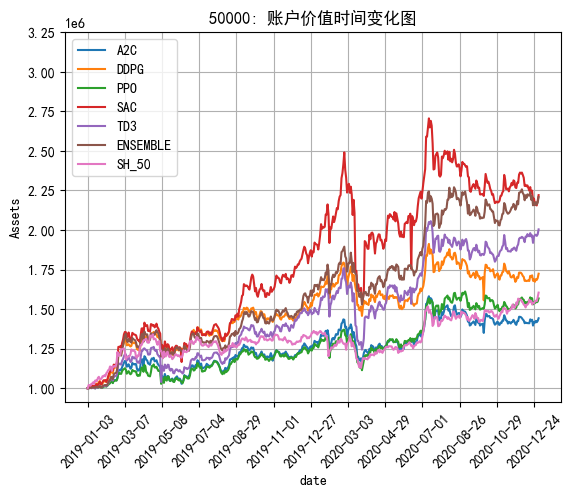

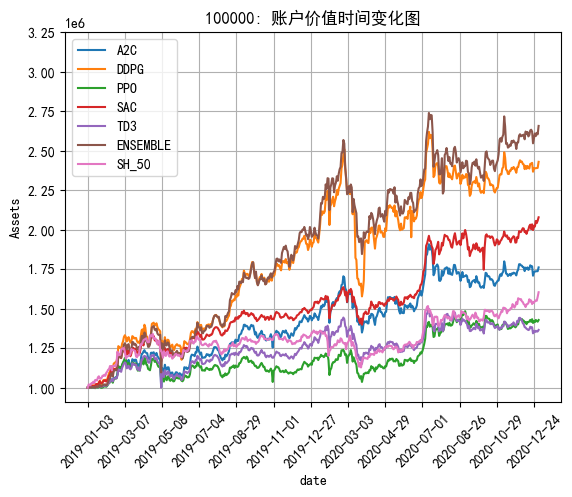

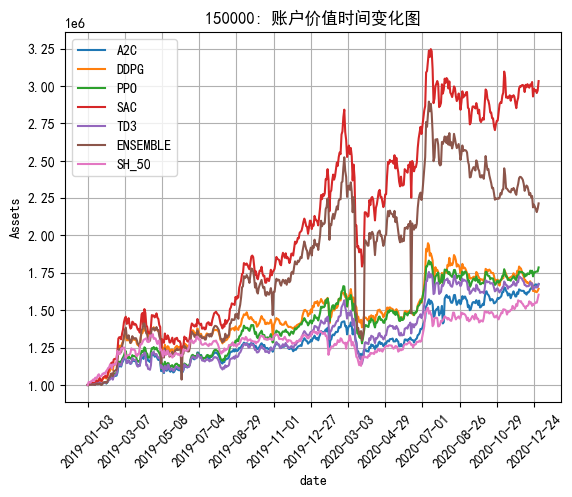

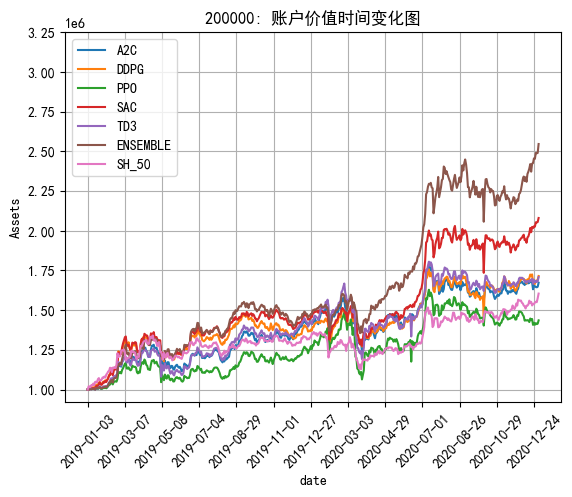

In [23]:
episode = 50000
episodes = [50000, 100000, 150000, 200000]
df_sh50 = pd.read_csv('./data_file/sh_50.csv')
df_sh50['total_assets'] = 1e6 / df_sh50['close'][0] * df_sh50['close']
info_sh50 = backtest_stats(df_sh50, value_col_name='total_assets')
info_sh50.to_csv("./backtest/sh50info.csv")
for episode in episodes:
    A2C_path = "./backtest/" + 'A2C' + f"{episode}" + 'account.csv'
    DDPG_path = "./backtest/" + 'DDPG' + f"{episode}" + 'account.csv'
    PPO_path = "./backtest/" + 'PPO' + f"{episode}" + 'account.csv'
    SAC_path = "./backtest/" + 'SAC' + f"{episode}" + 'account.csv'
    TD3_path = "./backtest/" + 'TD3' + f"{episode}" + 'account.csv'
    ensemble_path = "./backtest/" + 'Ensemble' + f"{episode}" + 'account.csv'

    df_A2C = pd.read_csv(A2C_path)
    df_DDPG = pd.read_csv(DDPG_path)
    df_PPO = pd.read_csv(PPO_path)
    df_SAC = pd.read_csv(SAC_path)
    df_TD3 = pd.read_csv(TD3_path)
    df_ensemble = pd.read_csv(ensemble_path)

    info_A2C = backtest_stats(df_A2C, value_col_name='total_assets')
    info_DDPG = backtest_stats(df_DDPG, value_col_name='total_assets')
    info_PPO = backtest_stats(df_PPO, value_col_name='total_assets')
    info_SAC = backtest_stats(df_SAC, value_col_name='total_assets')
    info_TD3 = backtest_stats(df_TD3, value_col_name='total_assets')
    info_ensemble = backtest_stats(df_ensemble, value_col_name='total_assets')

    info_A2C_df = pd.DataFrame(info_A2C)
    info_A2C_df.to_csv(f"./backtest/A2C{episode}info.csv")

    info_DDPG_df = pd.DataFrame(info_DDPG)
    info_DDPG_df.to_csv(f"./backtest/DDPG{episode}info.csv")

    info_PPO_df = pd.DataFrame(info_PPO)
    info_PPO_df.to_csv(f"./backtest/PPO{episode}info.csv")

    info_SAC_df = pd.DataFrame(info_SAC)
    info_SAC_df.to_csv(f"./backtest/SAC{episode}info.csv")

    info_TD3_df = pd.DataFrame(info_TD3)
    info_TD3_df.to_csv(f"./backtest/TD3{episode}info.csv")

    info_ensemble_df = pd.DataFrame(info_ensemble)
    info_ensemble_df.to_csv(f"./backtest/ensemble{episode}info.csv")

    ### 生成资产价值随时间变动图
    x = df_A2C['date']
    y_A2C = df_A2C['total_assets']
    y_DDPG = df_DDPG['total_assets']
    y_PPO = df_PPO['total_assets']
    y_SAC = df_SAC['total_assets']
    y_TD3 = df_TD3['total_assets']
    y_ensemble = df_ensemble['total_assets']
    y_sh50 =1e6 / df_sh50['close'][0] * df_sh50['close']

    plt.rcParams['font.sans-serif'] = ['SimHei']
    ticker_spacing = 40
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y_A2C, label='A2C')
    ax.plot(x, y_DDPG, label='DDPG')
    ax.plot(x, y_PPO, label='PPO')
    ax.plot(x, y_SAC, label='SAC')
    ax.plot(x, y_TD3, label='TD3')
    ax.plot(x, y_ensemble, label='ENSEMBLE')
    ax.plot(x, y_sh50, label = 'SH_50')
    plt.title(f'{episode}: 账户价值时间变化图')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
    plt.yticks(np.arange(1e6, 3.26e6, 0.25e6))
    # 下面的rotation表示的是旋转角度
    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('Assets')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f"./backtest/{episode}account.jpeg")

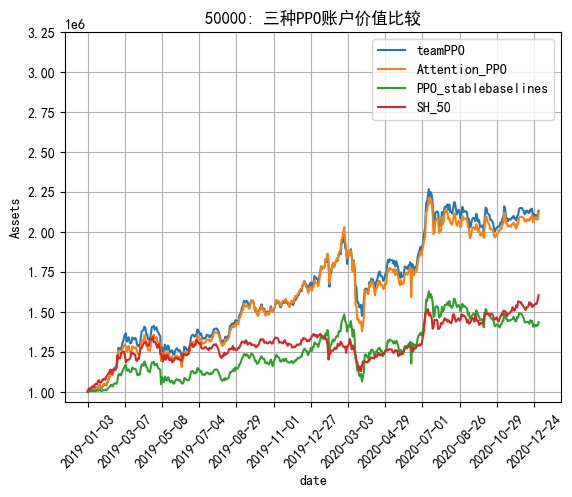

In [24]:
df_teamPPO = pd.read_csv("./backtest/teamPPO50000account.csv")
df_Attention_PPO = pd.read_csv("./backtest/Attention_PPO50000account.csv")
info_teamPPO = backtest_stats(df_teamPPO, value_col_name='total_assets')
info_Attention_PPO = backtest_stats(df_Attention_PPO, value_col_name='total_assets')
info_teamPPO.to_csv("./backtest/teamPPO50000info.csv")
info_Attention_PPO.to_csv("./backtest/Attention_PPO50000info.csv")

y_teamPPO = df_teamPPO['total_assets']
y_Attention_PPO = df_Attention_PPO['total_assets']
y_PPO = df_PPO['total_assets']

plt.rcParams['font.sans-serif'] = ['SimHei']
ticker_spacing = 40
fig, ax = plt.subplots(1, 1)
ax.plot(x, y_teamPPO, label='teamPPO')
ax.plot(x, y_Attention_PPO, label='Attention_PPO')
ax.plot(x, y_PPO, label='PPO_stablebaselines')
ax.plot(x, y_sh50, label = 'SH_50')

plt.title('50000: 三种PPO账户价值比较')

ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.yticks(np.arange(1e6, 3.26e6, 0.25e6))
# 下面的rotation表示的是旋转角度
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('Assets')
plt.grid()
plt.legend()
plt.show()
fig.savefig("./backtest/50000PPO_compare.jpeg")